In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("coffee_reviews_parsed.csv")

df.head()

,URL,all_text,Rating,Roaster,Coffee Name,Roaster Location,Coffee Origin,Roast Level,Agtron,Est. Price,...,Acidity,Acidity/Structure,Body,Flavor,Aftertaste,With Milk,Blind Assessment,Notes,Who Should Drink It,Bottom Line
0,https://www.coffeereview.com/review/100-arabic...,89\nCaffe Bomrad\n100% Arabica 100% Italiano\n...,89.0,Caffe Bomrad,100% Arabica 100% Italiano,"Torino, Italy",Not disclosed.,Medium,48/65,$54.00/1 Kilogram,...,NaN,NaN,8.0,8.0,7.0,8.0,Evaluated as espresso. Smoothly round aroma: t...,Roasted in Northern Italy and distributed in N...,A strong-charactered Northern Italian styled e...,NaN
1,https://www.coffeereview.com/review/100-arabic...,"87\nLucaff?\n100% Arabica, Black Label (ESE po...",87.0,Lucaff?,"100% Arabica, Black Label (ESE pod)","Padenghe sul Garda, Italy",Not disclosed.,Dark,0/80,NaN,...,NaN,NaN,8.0,7.0,7.0,8.0,Produced from an ESE pod on a FrancisFrancis! ...,ESE (Easy Serving Espresso) pods are wafer-lik...,An attractive pod espresso for big milk drinks.,NaN
2,https://www.coffeereview.com/review/100-arabic...,87\nCaribeans\n100% Arabica Coffee from Puerto...,87.0,Caribeans,100% Arabica Coffee from Puerto Rico,"San Juan, Puerto Rico","Utuado, central Puerto Rico",Medium-Light,54/69,$17.00/8 ounces,...,7.0,NaN,7.0,8.0,7.0,NaN,Bittersweet but balanced; chocolaty. Dark choc...,Produced on a single farm in the central mount...,NaN,Satisfying chocolate and nut notes nearly carr...
3,https://www.coffeereview.com/review/100-arabic...,88\nWaka Coffee\n100% Arabica Freeze-Dried Col...,88.0,Waka Coffee,100% Arabica Freeze-Dried Colombian (Instant C...,"Los Angeles, California",Colombia,NaN,0/0,$10.99/8 single-serve packets,...,NaN,7.0,8.0,8.0,8.0,NaN,Evaluated at proportions of 5 grams of instant...,The green coffee for this product was produced...,NaN,A appealing 100% Colombia coffee in instant fo...
4,https://www.coffeereview.com/review/100-arabic...,72\nYuban\n100% Arabica Instant Coffee\nRoaste...,72.0,Yuban,100% Arabica Instant Coffee,"Northfield, Illinois",Colombia. All coffee of the Arabica species.,NaN,0/0,$8.27/8 ounces instant,...,4.0,NaN,7.0,3.0,4.0,NaN,In the aroma caramel and wet burned wood notes...,An instant coffee evaluated as mixed in propor...,"Not good, but not the worst of the instants on...",NaN


In [2]:
# Check for missing data
df.isnull().sum()

URL                       0
all_text                  0
Rating                    5
Roaster                   5
Coffee Name               5
Roaster Location        106
Coffee Origin           572
Roast Level             506
Agtron                  103
Est. Price             2141
Review Date               0
Aroma                   167
Acidity                4679
Acidity/Structure      5117
Body                    116
Flavor                  120
Aftertaste              974
With Milk              7242
Blind Assessment         11
Notes                     3
Who Should Drink It    4360
Bottom Line            4182
dtype: int64

## Task: Clean Est. Price
- Problem: Inconsistent currency, price, quantity, and units
- Solution: 
    - Step 1: Break Est. Price into 4 columns: (currency, price, quantity, and units)
    - Step 2: Standard currency and price into USD and quantity and units into # of 100g
    - Step 3: Standardize into column USD_per_100g
    - Step 4: Adjust inflation based on review date


## Step 1
- Break Est. Price into 4 columns: (currency, price, quantity, and units)

In [3]:
import re

# Mapping word numbers to digits
number_words = {
    'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
    'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'eleven': 11, 'twelve': 12
}

# Common currency normalization
currency_map = {
    'NT': 'TWD', 'NTD': 'TWD', 'NT$': 'TWD', 'TWD': 'TWD',
    'AUD': 'AUD', 'USD': 'USD', '$': 'USD', 'US': 'USD', 'CAD': 'CAD',
    'HKD': 'HKD', 'HK': 'HKD', 'KRW': 'KRW', 'KRW$': 'KRW',
    'CNY': 'CNY', 'RMB': 'CNY', 'GBP': 'GBP', '£': 'GBP',
    'AED': 'AED', 'RM': 'MYR', 'GTQ': 'GTQ', 'E': 'EUR',
    'EURO': 'EUR', 'PUERTO': 'USD', 'NTD$': 'TWD'
}

def parse_price_info(text):
    text = str(text).strip().upper().replace(",", "")
    if text in ['NA', '', 'NAN']:
        return "USD", None, None, None

    # Capture currency code or symbol (e.g., NT$, AUD, £, $)
    currency_match = re.match(r"([A-Z]{2,4}[$]?)|([$£])", text)
    currency_raw = currency_match.group(0) if currency_match else "$"

    # Normalize currency
    currency = currency_map.get(currency_raw.replace("$", ""), "USD")

    # Remove leading currency code/symbol
    text_clean = text.replace(currency_raw, "", 1).strip()

    # Match price like $12.00 or 29.95
    match = re.search(r"(\d+(?:\.\d+)?)\s*/?\s*([\w\-\.]+)?[\s\-]?([\w\.]+)?", text_clean)
    if not match:
        return currency, None, None, None

    try:
        price = float(match.group(1))
    except:
        return currency, None, None, None

    # Extract quantity
    quantity_raw = match.group(2)
    unit = match.group(3) if match.group(3) else "unit"

    # Try to parse quantity
    if quantity_raw:
        quantity = number_words.get(quantity_raw.lower(), None)
        if quantity is None:
            try:
                quantity = float(quantity_raw)
            except:
                quantity = 1.0
    else:
        quantity = 1.0

    # Clean unit
    unit = unit.strip().lower().rstrip("s").replace("oz.", "ounce").replace("oz", "ounce")

    return currency, price, quantity, unit

# Usage
df[['currency', 'price', 'quantity', 'unit']] = df['Est. Price'].apply(
    lambda x: pd.Series(parse_price_info(x))
)

df.head()

,URL,all_text,Rating,Roaster,Coffee Name,Roaster Location,Coffee Origin,Roast Level,Agtron,Est. Price,...,Aftertaste,With Milk,Blind Assessment,Notes,Who Should Drink It,Bottom Line,currency,price,quantity,unit
0,https://www.coffeereview.com/review/100-arabic...,89\nCaffe Bomrad\n100% Arabica 100% Italiano\n...,89.0,Caffe Bomrad,100% Arabica 100% Italiano,"Torino, Italy",Not disclosed.,Medium,48/65,$54.00/1 Kilogram,...,7.0,8.0,Evaluated as espresso. Smoothly round aroma: t...,Roasted in Northern Italy and distributed in N...,A strong-charactered Northern Italian styled e...,NaN,USD,54.00,1.0,kilogram
1,https://www.coffeereview.com/review/100-arabic...,"87\nLucaff?\n100% Arabica, Black Label (ESE po...",87.0,Lucaff?,"100% Arabica, Black Label (ESE pod)","Padenghe sul Garda, Italy",Not disclosed.,Dark,0/80,NaN,...,7.0,8.0,Produced from an ESE pod on a FrancisFrancis! ...,ESE (Easy Serving Espresso) pods are wafer-lik...,An attractive pod espresso for big milk drinks.,NaN,USD,NaN,NaN,None
2,https://www.coffeereview.com/review/100-arabic...,87\nCaribeans\n100% Arabica Coffee from Puerto...,87.0,Caribeans,100% Arabica Coffee from Puerto Rico,"San Juan, Puerto Rico","Utuado, central Puerto Rico",Medium-Light,54/69,$17.00/8 ounces,...,7.0,NaN,Bittersweet but balanced; chocolaty. Dark choc...,Produced on a single farm in the central mount...,NaN,Satisfying chocolate and nut notes nearly carr...,USD,17.00,8.0,ounce
3,https://www.coffeereview.com/review/100-arabic...,88\nWaka Coffee\n100% Arabica Freeze-Dried Col...,88.0,Waka Coffee,100% Arabica Freeze-Dried Colombian (Instant C...,"Los Angeles, California",Colombia,NaN,0/0,$10.99/8 single-serve packets,...,8.0,NaN,Evaluated at proportions of 5 grams of instant...,The green coffee for this product was produced...,NaN,A appealing 100% Colombia coffee in instant fo...,USD,10.99,8.0,single
4,https://www.coffeereview.com/review/100-arabic...,72\nYuban\n100% Arabica Instant Coffee\nRoaste...,72.0,Yuban,100% Arabica Instant Coffee,"Northfield, Illinois",Colombia. All coffee of the Arabica species.,NaN,0/0,$8.27/8 ounces instant,...,4.0,NaN,In the aroma caramel and wet burned wood notes...,An instant coffee evaluated as mixed in propor...,"Not good, but not the worst of the instants on...",NaN,USD,8.27,8.0,ounce


In [4]:
# Check for missing data 
df.isnull().sum()
# About 2150 missing after cleaning

URL                       0
all_text                  0
Rating                    5
Roaster                   5
Coffee Name               5
Roaster Location        106
Coffee Origin           572
Roast Level             506
Agtron                  103
Est. Price             2141
Review Date               0
Aroma                   167
Acidity                4679
Acidity/Structure      5117
Body                    116
Flavor                  120
Aftertaste              974
With Milk              7242
Blind Assessment         11
Notes                     3
Who Should Drink It    4360
Bottom Line            4182
currency                  0
price                  2150
quantity               2150
unit                   2150
dtype: int64

In [5]:
# of unique vals to combine 4 columns into two (standardize currency and units)
# Unique values in the 'currency' column
print(df['currency'].unique())

# Unique values in the 'unit' column
print(df['unit'].unique())


['USD' 'TWD' 'CAD' 'GBP' 'CNY' 'AUD' 'HKD' 'KRW' 'GTQ' 'AED' 'MYR']
['kilogram' None 'ounce' 'single' 'realcup' 'k' 'unit' 'gram' '5' '18'
 '10.5' '8' 'can' 'ml.' 'g.' 'capsule' 'bottle' 'ml' 'ounces.' 'fluid'
 '12' 'of' '9.5' 'kg.' 'pod' 'pound' 'capsulte' 'set' '8.4' 'vue' 'g'
 '250g' 'once' '6' 'packet' 't' '1.6' 'tin' 'kilo' 'stick' '3.3' 'ouncue']


## Step 2
- Standard currency and price into USD and quantity and units into # of 100g

In [6]:
# Convert all currency into usd and all units into 100g
import pandas as pd

def convert_to_usd_and_100g(df):
    # Currency exchange rates to USD (as of April 2025 - adjust as needed)
    exchange_rates = {
        'USD': 1,
        'TWD': 0.032,
        'CAD': 0.74,
        'GBP': 1.31,
        'CNY': 0.14,
        'AUD': 0.63,
        'HKD': 0.13,
        'KRW': 0.00069,
        'GTQ': 0.13,
        'AED': 0.27,
        'MYR': 0.24
    }

    # Unit to grams (approximate where needed)
    unit_to_grams = {
        'kilogram': 1000,
        'kg': 1000,
        'kg.': 1000,
        'kilo': 1000,
        'gram': 1,
        'g': 1,
        'g.': 1,
        '250g': 250,
        'ounce': 28.3495,
        'ounces.': 28.3495,
        'ouncue': 28.3495,  # assumed typo
        'pound': 453.592,
        'ml': 1,
        'ml.': 1,
        'fluid': 1,  # assuming 1 ml = 1g (like water)
        'once': 28.3495,  # assumed typo
        't': 1.6,  # assumed teaspoon (average density-dependent)
        'single': 30,
        'unit': 30,
        'capsule': 10,
        'capsulte': 10,
        'pod': 10,
        'packet': 20,
        'can': 330,
        'bottle': 500,
        'set': 100,
        'stick': 5,
        'tin': 400,
        'vue': 50,
        'realcup': 240,
        # numeric/ambiguous values - default 100g unless clarified
        # '5': 100, '6': 100, '8': 100, '8.4': 100, '9.5': 100, '10.5': 100, '12': 100, '18': 100, 'of': 100, '1.6': 100
    }

    def get_price_usd(row):
        rate = exchange_rates.get(str(row['currency']).strip().upper(), None)
        if rate is None or pd.isnull(row['price']):
            return None
        return float(row['price']) * rate

    def get_quantity_100g(row):
        unit = str(row['unit']).strip().lower() if pd.notnull(row['unit']) else None
        grams = unit_to_grams.get(unit, None)
        if grams is None or pd.isnull(row['quantity']):
            return None
        quantity_grams = float(row['quantity']) * grams
        return quantity_grams / 100  # Convert to number of 100g units

    df['price_usd'] = df.apply(get_price_usd, axis=1)
    df['quantity_100g'] = df.apply(get_quantity_100g, axis=1)

    return df[['price_usd', 'quantity_100g']]


## Step 3: 
- Standardize into column USD_per_100g

In [7]:
# Then combine the two columns into the final column: usd_per_100g
def calculate_usd_per_100g(df):
    # First, convert price and quantity
    df_converted = convert_to_usd_and_100g(df.copy())

    # Calculate usd_per_100g, handling division-by-zero or nulls
    df_converted['usd_per_100g'] = df_converted.apply(
        lambda row: row['price_usd'] / row['quantity_100g']
        if pd.notnull(row['price_usd']) and pd.notnull(row['quantity_100g']) and row['quantity_100g'] != 0
        else None,
        axis=1
    )

    # Add the usd_per_100g column back into the original df
    df['usd_per_100g'] = df_converted['usd_per_100g']

    return df

df = calculate_usd_per_100g(df)

In [10]:
# Drop all data with no price
# Before dropping
print(df.shape)

# Drop rows with null in usd_per_100g
df = df.dropna(subset=['usd_per_100g'])

# After dropping
print(df.shape)


(8387, 27)
(6161, 27)


In [11]:
# Check statistical distribution of the new column
df.describe()

,Rating,Aroma,Acidity,Acidity/Structure,Body,Flavor,Aftertaste,With Milk,price,quantity,usd_per_100g
count,6161.000000,6115.000000,2017.000000,3242.000000,6154.000000,6152.000000,6152.000000,907.000000,6161.000000,6161.000000,6161.000000
mean,92.516962,8.705642,8.166088,8.512647,8.471401,8.858420,8.069246,8.657111,289.756234,42.876869,61.324816
std,2.472199,0.606388,0.789113,0.596188,0.577134,0.591173,0.644184,0.625402,3279.754874,84.435594,1939.755830
min,52.000000,2.000000,1.000000,1.000000,5.000000,1.000000,2.000000,5.000000,2.000000,0.800000,0.223177
25%,92.000000,8.000000,8.000000,8.000000,8.000000,9.000000,8.000000,8.000000,15.950000,12.000000,4.404840
50%,93.000000,9.000000,8.000000,9.000000,9.000000,9.000000,8.000000,9.000000,20.000000,12.000000,5.511561
75%,94.000000,9.000000,9.000000,9.000000,9.000000,9.000000,8.000000,9.000000,50.000000,12.000000,7.936648
max,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,120000.000000,554.000000,116666.666667


In [12]:
# Drop extreme outliers (anything above 200$ for a bag of coffee)
# Calculate the 97th percentile (top 3% threshold)
threshold = df['usd_per_100g'].quantile(0.97)

# Keep only rows below or equal to the 97th percentile
df = df[df['usd_per_100g'] <= threshold]


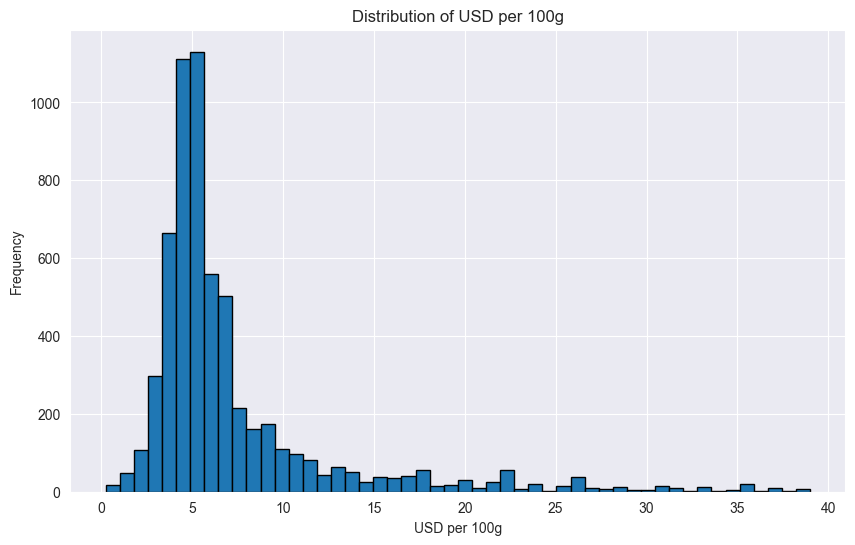

In [13]:
# Visualize price
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['usd_per_100g'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of USD per 100g')
plt.xlabel('USD per 100g')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Step 4: 
- Adjust inflation based on review date

In [17]:
# convert the column in datetime
# Convert the 'Review Date' to datetime (assumes format like "November 2011")
df['review_date'] = pd.to_datetime(df['Review Date'], format='%B %Y', errors='coerce')

# Extract the year
df['review_year'] = df['review_date'].dt.year


In [18]:
# Check the range of years to gather corresponding CPI
df['review_year'].unique()

array([2011, 2017, 2018, 2012, 2016, 2013, 2020, 2010, 2015, 2024, 2019,
       2021, 2014, 2023, 2022, 2025, 2009])

In [20]:
# adjust price based on inflation
def adjust_for_inflation(row):
    cpi_data = {
        1997: 160.5, 1998: 163.0, 1999: 166.6, 2000: 172.2, 2001: 177.1,
        2002: 179.9, 2003: 184.0, 2004: 188.9, 2005: 195.3, 2006: 201.6,
        2007: 207.3, 2008: 215.3, 2009: 214.5, 2010: 218.1, 2011: 224.9,
        2012: 229.6, 2013: 233.0, 2014: 236.7, 2015: 237.0, 2016: 240.0,
        2017: 245.1, 2018: 251.1, 2019: 255.7, 2020: 258.8, 2021: 271.0,
        2022: 292.7, 2023: 304.7, 2024: 314.4,
    }
    base_year = 2024
    cpi_base = cpi_data[base_year]

    year = row['review_year']
    cpi_year = cpi_data.get(year)

    if cpi_year and pd.notnull(row['usd_per_100g']):
        return row['usd_per_100g'] * (cpi_base / cpi_year) # Adjust inflation formula
    else:
        return None

df['usd_per_100g_adj'] = df.apply(adjust_for_inflation, axis=1)


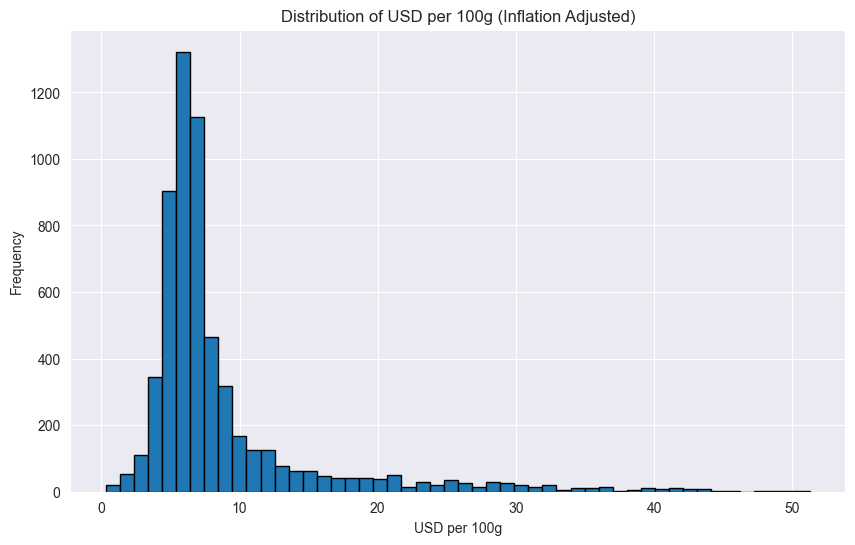

In [23]:
# Visualize inflation adjusted price
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['usd_per_100g_adj'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of USD per 100g (Inflation Adjusted)')
plt.xlabel('USD per 100g')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [24]:
# Export only the 'URL' and 'usd_per_100g_adj' columns
df[['URL', 'usd_per_100g_adj']].to_csv('adjusted_prices.csv', index=False)


## End of Price Adjustment Data Cleaning